Stochastic Modelling and Simulation project:
Multi-Robot Target Search using Probabilistic Consensus on Discrete Markov Chains.

In [57]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from Agent import Agent
from GridGraph import GridGraph

In [58]:
np.random.seed(12345)

Utility class to manage agents:

Experimental parameter:

In [59]:
N = 3 # number of agents

alpha = 0.08 # to be chosen in (0, 1/d_max) <- d_max = N-1

map_width = 3 # (meters)
map_height = 3

S = map_width * map_height # number of nodes (locations)


Graph initialization:

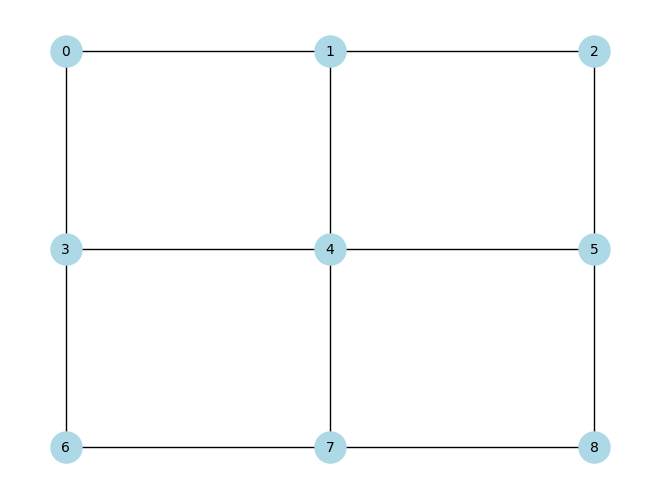

In [60]:
grid_graph = GridGraph(map_width, map_height)
grid_graph.plot_graph() 

In [61]:
def plot_graph_with_agents(graph, agent_list):
    """
    Plots the grid graph with agent positions marked in red.
    
    Parameters:
    - grid_graph: GridGraph object
    - agents: list of Agent objects
    """
    # Define the node positions in a grid layout
    pos = {i * graph.m + j: (j, -i) for i in range(graph.n) for j in range(graph.m)}
    
    # Get the positions of the agents
    agent_positions = [agent.getPosition() for agent in agent_list]

    # Prepare node colors (red for nodes with agents, lightblue for others)
    node_colors = ['red' if node in agent_positions else 'lightblue' for node in graph.graph.nodes()]

    # Plot the graph
    nx.draw(graph.graph, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10)
    plt.show()

Target init:

In [62]:
reference_information_state = 1
Z_r = [4, 5, 6] 
print("The reference information state is: " + str(reference_information_state))
print("Target is observable from nodes: " + str(Z_r))

The reference information state is: 1
Target is observable from nodes: [4, 5, 6]


Transition matrix:

In [63]:
def build_transition_matrix(graph):
    """ Method to build the transition matrix with an equal probability to go up, down, left or right in the grid"""
    t_m = np.zeros([S,S])
    edges = graph.edges()
    for row in range(S):
        for col in range(S):
            if row!=col and (row, col) in edges:
                t_m[row][col] = 1/len([edge for edge in edges if edge[0] == row or edge[1] == row])
    defined_check(t_m)
    return t_m
    
def defined_check(M: np.matrix)->None:
    """ It will check if the given transition matrix is well-defined """
    #Check if the matrix is squared
    if np.shape(M)[0]!=np.shape(M)[1]:
       raise RuntimeError("Number of rows is different from the number of columns")

    for i in range(len(M)):
        s = 0
        
        for j in range(len(M)):
            #Check if the values are actualy probabilities
            if M[i,j]>1 or M[i,j]<0:
                raise RuntimeError("An element of the transition matrix is not a probability: "+str(i)+","+str(j))
            
            s = s + M[i,j]

        #Check if the rows sum up to 1
        if s-1>0.00000001:
            raise RuntimeError("The matrix is not well defined. Goes over 1 in the row "+str(i)+" with a value "+str(s))
         

In [64]:
P = build_transition_matrix(grid_graph)

Agents init:

In [65]:
agents = []

for i in range(N):
    initial_node = np.random.randint(0, S)
    agent = Agent(i+1, initial_node)
    agents.append(agent)
    print(agent)
    

Agent ID: 1, 
Position: 2 
Information state: 0.8901547142593231

Agent ID: 2, 
Position: 1 
Information state: 0.18391881167709445

Agent ID: 3, 
Position: 5 
Information state: 0.5320779204036645


In [66]:
def check_consensus(agents_array, ref_information_state, eps):
    for ag in agents_array:
        if abs(ag.getInformationState() - ref_information_state) > eps:
            return False # at least one agent doesn't reach the reference state
    return True

In [67]:
def getNeighbors(_agent, _agents):
    position = _agent.getPosition()
    neighbors = []
    for a in _agents:
        if a != _agent and a.getPosition() == position:
            neighbors.append(a)
    return neighbors

In [68]:
def build_graph_laplacian(actors):
    matrix =  np.zeros((N, N))
    for ii in range(N):
        matrix[ii][ii] = len(getNeighbors(actors[ii], actors))
    for j in range(N):
        for l in range(N):
            if j != l:
                if actors[j].getPosition() == actors[l].getPosition():
                    matrix[j][l] = -1
                else:
                    matrix[j][l] = 0
    print("Laplacian: ", matrix)
    return matrix

In [69]:
def build_augmented_information_state_vector(actors):
    vector = []
    for a in actors:
        vector.append(a.getInformationState())
    vector.append(reference_information_state)
    column_vector = np.array(vector).reshape(-1,1)
    print("information vector: ", column_vector)
    return column_vector

def build_transition_information_states_matrix(agent_list):
    L = build_graph_laplacian(agent_list)
    I = np.eye(N)
        
    # build d -> agent who finds the target
    d = []
    for index in range(N):
        if agent_list[index].getPosition() in Z_r:
            d.append(1)
        else:
            d.append(0)
    
    print("d = ", d)
    element_11 = I - alpha*L + np.diag(d)
    element_12 = [-x for x in d]  
    element_12_T = np.array(element_12).reshape(-1, 1)
    # element_12_T = np.array(d).reshape(-1, 1)
    # element_21 = np.zeros(N)  
    # element_22 = 1  
    element_21 = np.zeros((1, N))
    element_22 = np.array([[1]])
    
    H = np.block([
        [element_11, element_12_T], [element_21, element_22]
    ])
    
    #new_information_state_vector = np.matmul(H,information_states)
    #print(new_information_state_vector)
    # return new_information_state_vector
    print("H = ", H)
    
    # return np.matmul(H,information_states)
    return H
# build_transition_information_states_matrix(agents)

In [70]:
def __cumulativeTransformer(p0:np.array)->np.array:
    """
    Given a probability array this function will compute the cumulative of such distribution.
    """
    p = np.zeros(len(p0),dtype=float)
    p[0] = p0[0]

    for i in range(1,len(p)):
        p[i] = p0[i] + p[i-1]
    
    return p

def obtainState(p0:np.array)->int:
    """
    Given a probability distribution of the state this function will
    produce a weighted random state.
    """
    p = __cumulativeTransformer(p0)

    random_state = np.random.uniform()
    s = 0
    for i in range(len(p0)):
        if (random_state < p[i]) and ((p[i] - p[i - 1]) > 0.0000001):
            s = i
            break
    
    return s

In [71]:
print(obtainState(P[0]))

3


In [72]:
class RandomWalkController:
    
    def __init__(self, _agents, _graph):
        self.eps = 0.01
        self.agents = _agents
        self.graph = _graph
        self.k = 0
    
    def run(self):
        timer = 0
        while not check_consensus(self.agents, reference_information_state, self.eps) and timer < 2000:
            # plot_graph_with_agents(self.graph, self.agents)
            H_k = build_transition_information_states_matrix(self.agents)
            actual_information_state_vector = build_augmented_information_state_vector(self.agents)
            # print(H_k.shape)
            # print(H_k)
            # print(actual_information_state_vector.shape)
            # print(actual_information_state_vector)
            new_information_state_vector = np.matmul(H_k, actual_information_state_vector)
            self.update_agents_position()
            self.update_agents_information_state(new_information_state_vector[:-1, :])
            
            timer+=1
            
        file_name = "trajectories.txt"
        with open(file_name, 'w') as file:
            stringa = ""
            for agent in self.agents:
                stringa += (f"Agent {agent.id_number}: \n State trajectory: {str(agent.getTrajectory())} \n Information state [k]:"
                            f" {np.array(agent.getInformationStateTrajectory()).__str__()} \n\n")
            # Scrivere ogni lista nel file
            file.write(stringa)
            #np.array(agent.getInformationStateTrajectory()).__str__()
            print("fatto")
            # file.write(", ".join(map(str, lista1)) + "\n")  # Converte i numeri in stringhe e li unisce con virgole
            
            # for _agent in self.agents:   
            #     sum1 = 0
            #     sum2 = 0
            #     N_ka = getNeighbors(_agent, agents)
            #     for b in N_ka:
            #         None # formula
            #     if _agent.getPosition() in Z_r:
            #         sum2 = -(_agent.getInformationState() - reference_information_state)
            #     
            #     information_state_k = _agent.getInformationState()
            #     _agent.updateInformationState(information_state_k + sum1 + sum2)
            #     print(build_graph_laplacian(self.agents))
            #     self.k += 1 # time

    def update_agents_position(self):
        for agent in self.agents:
            actual_state = agent.getPosition()
            new_state = obtainState(P[actual_state, :])
            agent.updatePosition(new_state)

    def update_agents_information_state(self, new_information_state):
        for (i, information_state) in enumerate(new_information_state):
            print(f"(i, information_state) = ({i},{information_state})")
            self.agents[i].updateInformationState(information_state[0])
            # self.agents[i].updateInformationState(max(information_state[0],0))
        


Graph class representing agent's environment

In [73]:
experiment = RandomWalkController(agents, grid_graph)
experiment.run()
# class Node:
#    def __init__(self, x, y):
        

Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 0, 1]
H =  [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  2. -1.]
 [ 0.  0.  0.  1.]]
information vector:  [[0.89015471]
 [0.18391881]
 [0.53207792]
 [1.        ]]
(i, information_state) = (0,[0.89015471])
(i, information_state) = (1,[0.18391881])
(i, information_state) = (2,[0.06415584])
Laplacian:  [[ 0.  0.  0.]
 [ 0.  1. -1.]
 [ 0. -1.  1.]]
d =  [0, 1, 1]
H =  [[ 1.    0.    0.    0.  ]
 [ 0.    1.92  0.08 -1.  ]
 [ 0.    0.08  1.92 -1.  ]
 [ 0.    0.    0.    1.  ]]
information vector:  [[0.89015471]
 [0.18391881]
 [0.06415584]
 [1.        ]]
(i, information_state) = (0,[0.89015471])
(i, information_state) = (1,[-0.64174341])
(i, information_state) = (2,[-0.86210728])
Laplacian:  [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
d =  [0, 0, 0]
H =  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
information vector:  [[ 0.89015471]
 [-0.64174341]
 [-0.86210728]
 [ 1.        ]]
(i, information_state) = (0,[0.89015471])
(i,